In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import seaborn as sns; sns.set()
import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.cluster import adjusted_rand_score

## 1. Exploratory Data Analysis

The dataset GSE45827 was taken from kaggle (https://www.kaggle.com/brunogrisci/breast-cancer-gene-expression-cumida). It represents gene expression data from breast cancer samples curated by the Curated Microarray Database CuMiDa (http://sbcb.inf.ufrgs.br/cumida#). CuMiDa is a repository for machine learning that contains 78 handpicked cancer microarray datasets from 30.000 studies from the Gene Expression Omnibus (GEO), a public functional genomics data repository (https://www.ncbi.nlm.nih.gov/geo/). The data is already in a pre-processed and normalized format ready to be used for experimental ML approaches.

In [32]:
# load dataset and explore the first rows
df = pd.read_csv('Breast.csv')
# columns_to_drop = ['Column1', 'Column2', 'Column3']  # Replace 'Column1', 'Column2', 'Column3' with the actual column names
# df = df.drop(columns=columns_to_drop, axis=1)
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [4]:
# retrieve number of rows and columns in the dataset
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns in the breast cancer data set')

There are 151 rows and 54677 columns in the breast cancer data set


In [5]:
# check for missing values in dataset
df.isnull().sum()

samples            0
type               0
1007_s_at          0
1053_at            0
117_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 54677, dtype: int64

In [6]:
# check for unique ID identifiers
print(f"The total ids are {df['samples'].count()}, from those the unique ids are {df['samples'].value_counts().shape[0]} ")

The total ids are 151, from those the unique ids are 151 


In [7]:
# check for label distribution
label_count = df['type'].value_counts()
label_count

type
basal        41
HER          30
luminal_B    30
luminal_A    29
cell_line    14
normal        7
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of label types in breast cancer data')

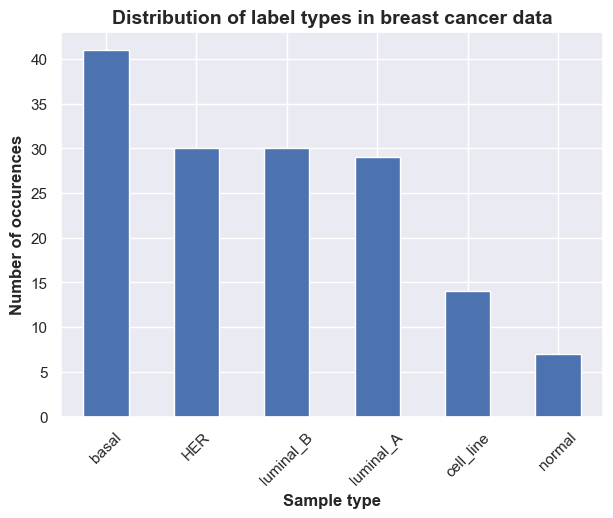

In [8]:
# visualize distribution of labels
fig = plt.figure(figsize=(7, 5))
df['type'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Number of occurences', fontsize=12, fontweight='bold')
plt.xlabel('Sample type', fontsize=12, fontweight='bold')
plt.title('Distribution of label types in breast cancer data', fontsize=14, fontweight='bold')

## 2. Data Preparation for Clustering

In [9]:
# assign labels to variable y
y = df['type']
y

0          basal
1          basal
2          basal
3          basal
4          basal
         ...    
146    luminal_B
147    luminal_B
148    luminal_B
149    luminal_B
150    luminal_B
Name: type, Length: 151, dtype: object

In [10]:
# select feature data for clustering
data = df.iloc[:,2:].values
data

array([[ 9.85003997,  8.09792735,  6.42472816, ...,  2.9666567 ,
         3.50849465,  3.30199869],
       [ 9.86135737,  8.21222225,  7.06259284, ...,  2.9347635 ,
         3.68766637,  3.06429903],
       [10.1034785 ,  8.93613685,  5.73596977, ...,  2.84768393,
         3.55059675,  3.15853522],
       ...,
       [11.02709803,  7.18087582,  6.30473602, ...,  3.0851274 ,
         3.62884807,  3.21580734],
       [10.44439499,  7.5251525 ,  5.9644598 , ...,  3.01852519,
         3.77059745,  3.10229782],
       [11.34581728,  7.3792993 ,  5.89117177, ...,  3.06158533,
         3.85752548,  3.12982746]])

Before applying clustering, we scale our data such that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of the features. Here we use the StandardScaler module for scaling the features individually. StandardScaler subtracts the mean from each feature and then scales to unit variance.

In [11]:
scaler = StandardScaler()

In [12]:
scaled_data = scaler.fit_transform(data)

In [13]:
scaled_data

array([[-0.79956253,  0.66184251,  0.31065541, ...,  0.51588188,
        -0.79712848,  1.26152126],
       [-0.78105222,  0.82416537,  1.30221516, ...,  0.17226811,
         0.43928775, -1.07876515],
       [-0.38504796,  1.85227675, -0.76001854, ..., -0.76591736,
        -0.50659316, -0.15095702],
       ...,
       [ 1.12558961, -0.64056402,  0.12412781, ...,  1.79227194,
         0.03339837,  0.41291911],
       [ 0.17254231, -0.15161854, -0.4048311 , ...,  1.07470717,
         1.01157301, -0.70464582],
       [ 1.64687488, -0.35876085, -0.51875725, ...,  1.53863231,
         1.61144015, -0.43360104]])

## 3. Clustering Approaches

In [14]:
### k-Means Clustering

Although the number of classes with 6 for the cancer subtypes is known for this dataset, perform a calculation and plotting of the cluster errors to see whether 6 is really the optimal size for k.

In [15]:
# Calculate the cluster errors for clusters from 1 to 15
cluster_range = range( 1, 20 )
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters, n_init = 10 )
  clusters.fit(scaled_data)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:20]

,num_clusters,cluster_errors
0,1,8.255925e+06
1,2,7.576451e+06
2,3,6.964871e+06
3,4,6.615490e+06
4,5,6.273270e+06
5,6,6.066957e+06
6,7,5.961449e+06
7,8,5.880459e+06
8,9,5.788034e+06
9,10,5.718186e+06


The total sum of squared distances of every data point from respective centroid is also called inertia. Let us print the inertia value for all k values. That k at which the inertia stop to drop significantly (elbow method) will be the best k.

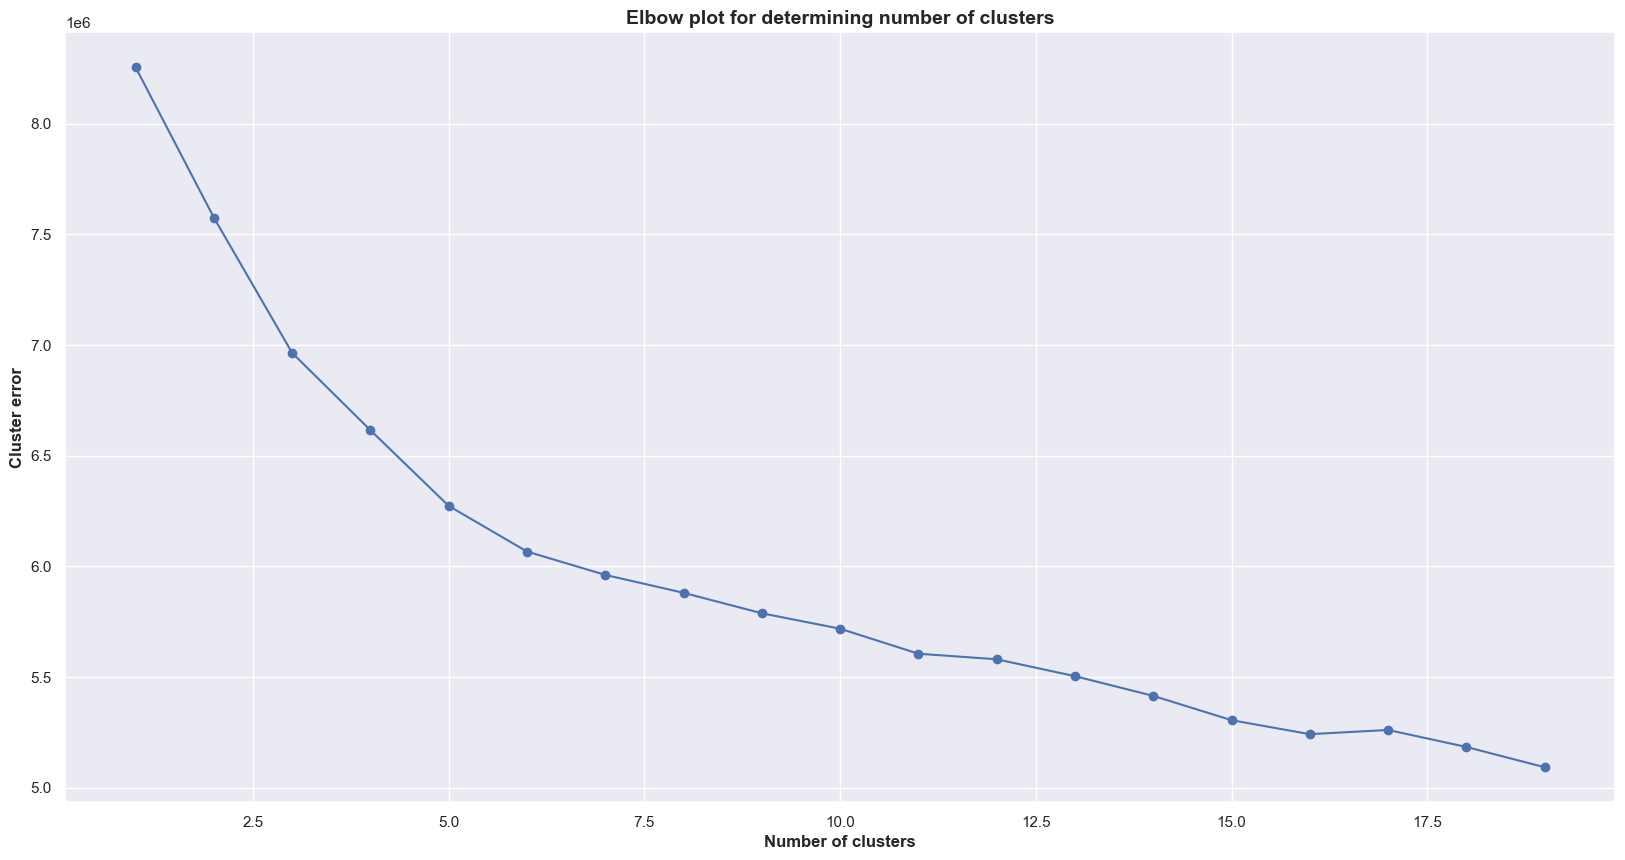

In [16]:
# Elbow plot
plt.figure(figsize=(20,10))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.xlabel('Number of clusters', fontsize=12, fontweight='bold')
plt.ylabel('Cluster error', fontsize=12, fontweight='bold')
plt.title('Elbow plot for determining number of clusters', fontsize=14, fontweight='bold')
plt.savefig('elbowplot.png')

In [17]:
# instantiate KMeans object
km = KMeans(n_clusters=6, random_state=0)

In [18]:
# predict the cluster labels
labels = km.fit_predict(scaled_data)

In [19]:
km.cluster_centers_.shape

(6, 54675)

In [20]:
centroids = km.cluster_centers_
print(centroids)

[[-2.76848088e+00  1.02251771e+00 -1.57550713e+00 ...  2.35071529e+00
   1.64294645e+00  1.66040031e+00]
 [ 4.62227794e-01 -3.69595851e-01  2.12180609e-01 ...  1.23100587e-01
  -6.06028344e-01 -1.24359702e-01]
 [ 7.75289786e-02  3.30203920e-01  3.06950349e-02 ... -2.82493183e-01
   1.37191873e-01 -4.09622644e-01]
 [ 4.11482282e-01 -8.45063598e-01 -2.76878121e-02 ... -6.63563479e-03
   2.43059724e-03  1.39308204e-01]
 [-1.48477108e-01  1.84775111e+00 -1.42720308e+00 ...  1.14719034e+00
   1.47748481e+00  6.94817217e-01]
 [-6.38747279e-01  3.41673143e-01  5.08154788e-01 ... -3.28296932e-01
  -4.72806722e-01 -4.56620921e-02]]


In [21]:
# print cluster labels
print(labels)

[5 5 5 5 5 5 5 5 5 5 5 2 2 5 2 2 2 2 5 5 2 5 5 5 5 5 2 2 2 5 2 2 2 2 2 2 2
 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 5 2 2 2 4 4 4
 4 4 4 4 4 4 0 0 0 4 4 3 1 3 3 3 3 3 3 3 3 3 1 3 1 1 3 3 3 3 3 3 3 3 1 1 3
 3 3 3 3 3 1 3 3 3 3 3 1 1 1 3 3 1 1 1 1 3 3 3 1 1 3 3 3 3 3 1 1 3 3 3 3 3
 3 3 3]


In [22]:
## creating a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(km.labels_ , columns = list(['label']))

df_labels['label'] = df_labels['label'].astype('category')

In [23]:
# Joining the label dataframe with the original data frame. 
df_labeled = df.join(df_labels)
df_labeled.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,label
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999,5
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299,5
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535,5
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665,5
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947,5


In [24]:
df_labeled['label'].value_counts()

label
3    48
2    38
5    33
1    18
4    11
0     3
Name: count, dtype: int64

### Evaluate k-means Clustering

There are several ways to evaluate a clustering. In the following the cluster error, the silhoutte plot and score as well as the accuracy are calculated. Since the data set already has labels assigned to it, it is possible to calculate the amount of correct cluster assignments
Calculatation of cluster error

In [25]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 6342071.14


### Apply PCA to data before clustering

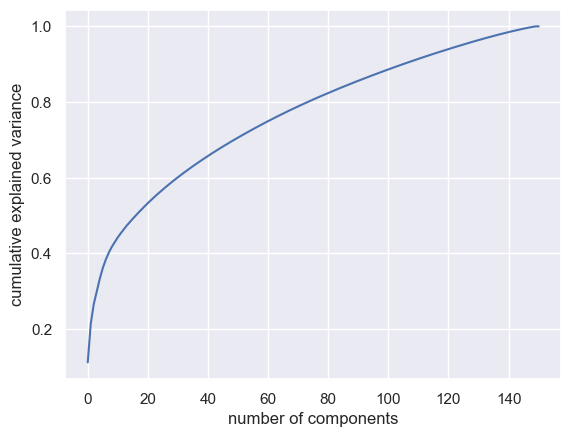

In [26]:
# In order to find the number of dimensions explaining most of the variety in the data, plot cumulative explained variance
pca_plot = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In order to explain 95% of data, one would need 100 principal components.

In [27]:

random_features = np.random.choice(df.columns, 100)

# Perform K-means on the random subspace
kmeans = KMeans(n_clusters=17) # Change the number of clusters as needed
kmeans.fit(df[random_features])

KMeans(n_clusters=17)

Davies-Bouldin score for 2 clusters: 2.109475296207169
Davies-Bouldin score for 3 clusters: 1.8935816842434967
Davies-Bouldin score for 4 clusters: 2.6324552935766103
Davies-Bouldin score for 5 clusters: 2.4367350965235013
Davies-Bouldin score for 6 clusters: 2.266518438088578
Davies-Bouldin score for 7 clusters: 2.499303614121826
Davies-Bouldin score for 8 clusters: 2.196105849872961
Davies-Bouldin score for 9 clusters: 2.079293360121258
Davies-Bouldin score for 10 clusters: 2.1215849583181976


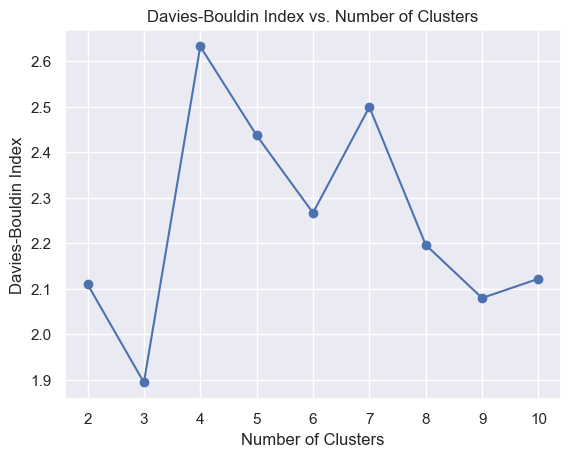

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Assuming df is your DataFrame
random_features = np.random.choice(df.columns, 100)

# Range of cluster numbers
k_values = range(2, 11)  # Adjusted to start from 2 as DBI requires at least 2 clusters
dbi_scores = []

# Perform K-means for each k and calculate the Davies-Bouldin Index
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(df[random_features])
    db_index = davies_bouldin_score(df[random_features], cluster_labels)
    dbi_scores.append(db_index)
    print(f'Davies-Bouldin score for {k} clusters: {db_index}')

# Plot Davies-Bouldin Index
plt.plot(k_values, dbi_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.grid(True)
plt.show()
